In [2]:
pip install pymysql

     |████████████████████████████████| 43 kB 2.1 MB/s 


In [23]:
from fbprophet import Prophet
import pandas as pd
import sqlalchemy
import pymysql
import datetime
from fbprophet.plot import add_changepoints_to_plot

In [24]:
data_year_1 = pd.read_excel("bd_futuros.xlsx")
data_year_1
data_year_1["Fecha"] = data_year_1["Fecha"].apply(lambda x: x.strftime("%Y-%m-%d"))

In [25]:
data_year_1["Fecha"] = pd.to_datetime(data_year_1["Fecha"])
data_year_1 = data_year_1[data_year_1["Producto"] == "SWBCCAL23"]

In [26]:
data_year_1

,Fecha,Producto,Precio
17,2020-01-02,SWBCCAL23,46.38
42,2020-01-03,SWBCCAL23,46.88
67,2020-01-06,SWBCCAL23,46.63
92,2020-01-07,SWBCCAL23,46.48
117,2020-01-08,SWBCCAL23,46.38
...,...,...,...
14587,2022-03-11,SWBCCAL23,148.00
14612,2022-03-14,SWBCCAL23,144.00
14637,2022-03-15,SWBCCAL23,140.00
14662,2022-03-16,SWBCCAL23,136.00


In [27]:
string = "2021-03-17"
string2 = datetime.datetime.strptime(string, '%Y-%m-%d').date()
string2 = pd.to_datetime(string2)

In [28]:
data_year_1 = data_year_1.rename(columns={"Fecha": "ds", "Precio": "y"})


In [29]:
data_year_1

,ds,Producto,y
17,2020-01-02,SWBCCAL23,46.38
42,2020-01-03,SWBCCAL23,46.88
67,2020-01-06,SWBCCAL23,46.63
92,2020-01-07,SWBCCAL23,46.48
117,2020-01-08,SWBCCAL23,46.38
...,...,...,...
14587,2022-03-11,SWBCCAL23,148.00
14612,2022-03-14,SWBCCAL23,144.00
14637,2022-03-15,SWBCCAL23,140.00
14662,2022-03-16,SWBCCAL23,136.00


In [30]:
data_year_1 = data_year_1[data_year_1['ds'] >= string2]

In [31]:
data_year_1

,ds,Producto,y
7788,2021-03-17,SWBCCAL23,43.40
7815,2021-03-18,SWBCCAL23,43.75
7842,2021-03-19,SWBCCAL23,44.00
7869,2021-03-22,SWBCCAL23,44.25
7896,2021-03-23,SWBCCAL23,44.25
...,...,...,...
14587,2022-03-11,SWBCCAL23,148.00
14612,2022-03-14,SWBCCAL23,144.00
14637,2022-03-15,SWBCCAL23,140.00
14662,2022-03-16,SWBCCAL23,136.00


In [32]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True)

In [33]:
m.fit(data_year_1)

In [34]:
future = m.make_future_dataframe(periods=30)  #crea 30 días despues de los que yo tengo
#mi df acaba el 17 de marzo y lo lleva hasta el 22 de abril

In [35]:
future

,ds
0,2021-03-17
1,2021-03-18
2,2021-03-19
3,2021-03-22
4,2021-03-23
...,...
285,2022-04-12
286,2022-04-13
287,2022-04-14
288,2022-04-15


In [36]:
future = future[future.ds.dt.weekday < 5] #lo dejamos sin fines de semana

In [37]:
future.head(10)

,ds
0,2021-03-17
1,2021-03-18
2,2021-03-19
3,2021-03-22
4,2021-03-23
5,2021-03-24
6,2021-03-25
7,2021-03-26
8,2021-03-29
9,2021-03-30


In [38]:
m2 = Prophet(mcmc_samples=40, daily_seasonality=True, yearly_seasonality=True)

In [39]:
control = {}
forecast = m2.fit(data_year_1, control=control).predict(future)

In [40]:
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [41]:
forecast

,ds,yhat,yhat_lower,yhat_upper
0,2021-03-17,51.110456,44.324528,58.397539
1,2021-03-18,49.648419,43.200399,57.301888
2,2021-03-19,47.824758,40.685954,54.976473
3,2021-03-22,44.203228,37.352646,50.793522
4,2021-03-23,43.650330,36.464501,50.484483
...,...,...,...,...
276,2022-04-11,134.847261,125.291518,145.305458
277,2022-04-12,135.833326,126.386103,145.400844
278,2022-04-13,136.308283,126.370167,146.223677
279,2022-04-14,136.550274,125.442590,146.408255


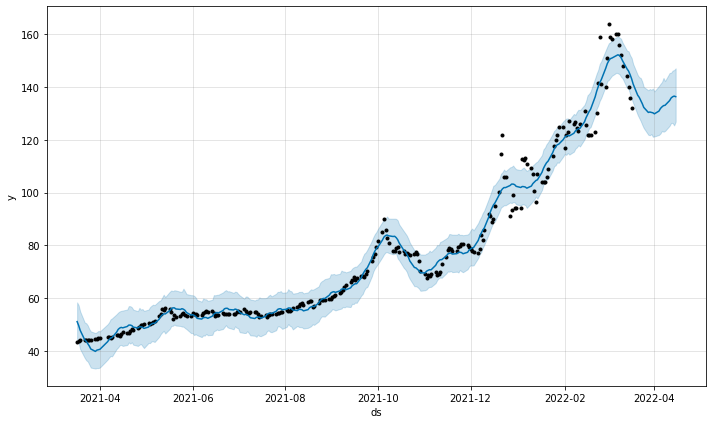

In [42]:

fig = m2.plot(forecast)

In [43]:
data_year_1['ds'] = pd.to_datetime(data_year_1['ds'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
df = forecast.merge(data_year_1, how='left', on='ds')
df = df.rename(columns={"y": "Y+1"})
df.to_excel("predictions_cal23_40samples.xlsx")